In [1]:
import os
import glob
import cv2
import shutil
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
import ultralytics
from ultralytics import YOLO
from ultralytics import RTDETR
ultralytics.checks()

Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Setup complete  (24 CPUs, 63.9 GB RAM, 1211.0/1907.7 GB disk)


# Split the files into jpg and csv directories for easier manipulation

In [6]:
path = "data/dataset/"

for f in os.listdir(path):
    # save path to file being opened as variable
    original_file_path = os.path.join(path, f)
    # check that it is actually a file being copied
    if os.path.isfile(original_file_path):
        # save the file name
        file_name = os.path.basename(original_file_path)
        # get the file extension (need it for the new directories)
        extension = f.split(".")[-1]
        extension_path = os.path.join(path, extension)

        # if directory doesn't exist, create directory
        if not os.path.exists(extension_path):
            os.makedirs(extension_path)

        # Copy the files into the new directory - we don't want to delete stuff and have to redownload if things go wrong
        shutil.copyfile(original_file_path, os.path.join(extension_path, file_name))

In [7]:
dir_path = "data/dataset/csv"
count = 0
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
count

12008

In [8]:
dir_path = "data/dataset/jpg"
count = 0
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
count

12008

# Get the classes we are working with

In [3]:
classes = []

for csv_file in os.listdir("data/dataset/csv"):

    csv = pd.read_csv("data/dataset/csv/" + csv_file)
    classes.append(csv["class"][0])

df = pd.DataFrame()

classes_srs = pd.Series(classes)

df["classes"] = classes_srs

df["classes"].value_counts()

classes
F16           604
F35           567
F15           557
C2            556
US2           501
C130          472
V22           467
F18           459
A10           335
B1            330
F4            321
C17           308
B2            301
F22           290
JAS39         277
C5            274
Vulcan        264
EF2000        260
MQ9           250
A400M         243
E2            239
AV8B          237
Rafale        235
Be200         232
J20           228
Tornado       227
F14           225
B52           224
Su34          214
RQ4           208
U2            201
Mig31         197
SR71          196
Tu160         187
Mirage2000    186
AG600         184
Su57          179
F117          157
P3            147
Tu95          145
XB70          139
E7             97
YF23           88
Name: count, dtype: int64

In [4]:
class_list = df["classes"].unique()

In [5]:
class_list = (np.sort(class_list))
class_list 

array(['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C2', 'C5', 'E2', 'E7', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'MQ9', 'Mig31', 'Mirage2000', 'P3', 'RQ4', 'Rafale', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22',
       'Vulcan', 'XB70', 'YF23'], dtype=object)

In [6]:
count_df = pd.DataFrame(df["classes"].value_counts())

In [7]:
count_df = count_df.reset_index()

In [8]:
count_df.head()

classes  count
0     F16    604
1     F35    567
2     F15    557
3      C2    556
4     US2    501

In [9]:
len(count_df.index)

43

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

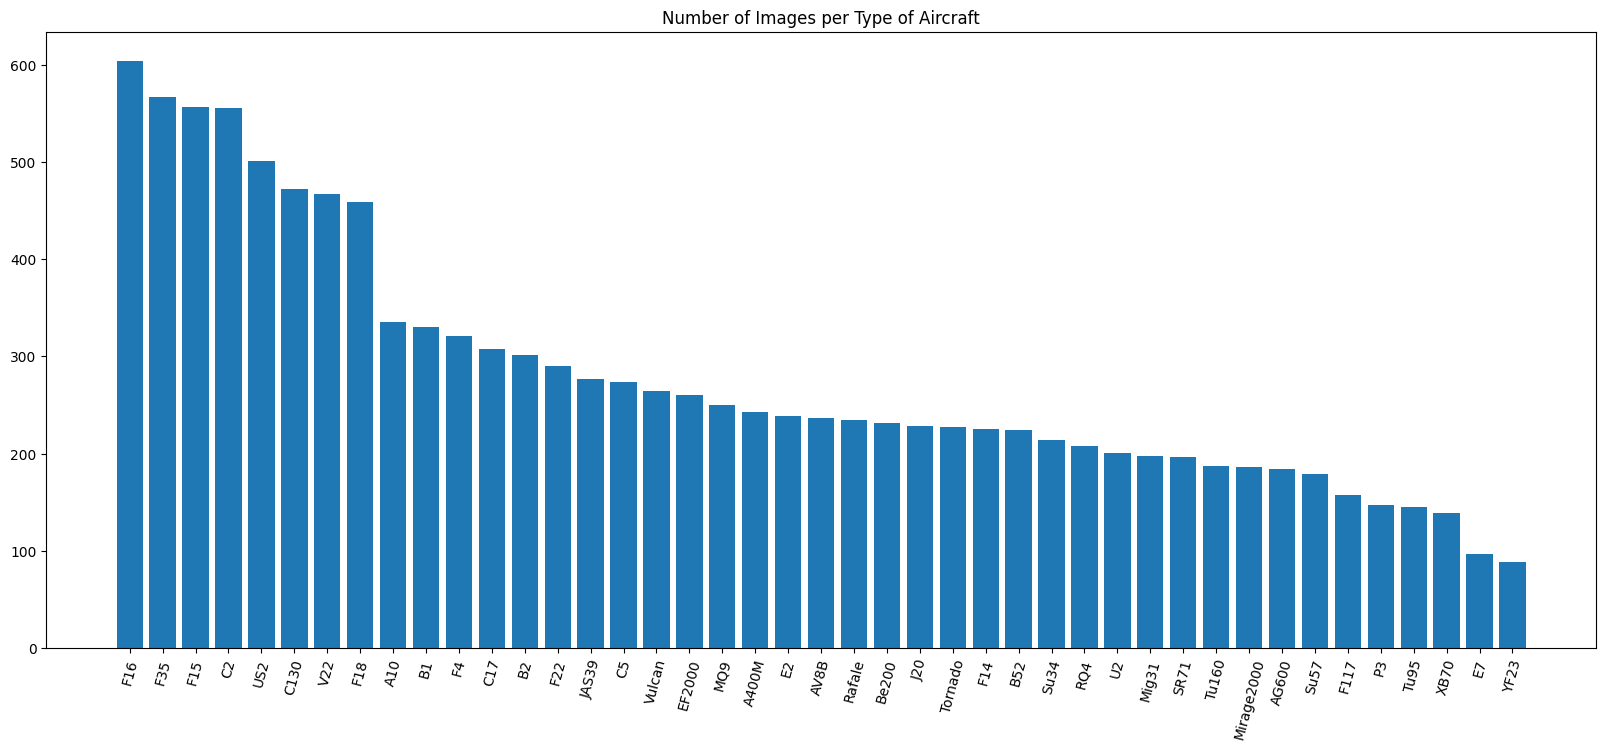

In [10]:
plt.figure(figsize = (20,8))
plt.title("Number of Images per Type of Aircraft") 
plt.bar(count_df["classes"], count_df["count"])
plt.xticks(rotation = 75)
plt.tight_layout


# Save the directories as variables for easy access

In [11]:
img_collection_path = "data/dataset/jpg"
annot_collection_path = "data/dataset/csv"

# Get all the file names alongside classes for train_test_split with stratified y

In [12]:
image_names = []
classes = []

In [13]:
for csv_file in os.listdir(annot_collection_path):

    csv = pd.read_csv("data/dataset/csv/" + csv_file)
    image_names.append(csv["filename"][0])
    classes.append(csv["class"][0])


In [14]:
df = pd.DataFrame()

name_srs = pd.Series(image_names)

classes_srs = pd.Series(classes)

df["images"] = name_srs

df["classes"] = classes_srs

In [15]:
df.head()

images classes
0  000106393cfe2343888c584e65fd2274     F16
1  00032844ab679240fc03ecd27d29a6aa     F18
2  0003f56298fa8999168d7988a2e9549d     F22
3  000aa01b25574f28b654718db0700f72     F35
4  000e7662268a1071827c5a8663e773f9     US2

In [16]:
X = df[["images"]]
y = df["classes"]

# Train_test_split to get a validation dataset

In [17]:
x_train, x_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=666)

In [18]:
y_val_df = pd.DataFrame(y_val)
val_df = pd.concat([x_val, y_val_df], axis=1)
val_df

images classes
4053   56fb1f83ad986c829218fdf326a51b77  Vulcan
868    122d7ee3c1a2931db985f9249a41d004      P3
11607  f802a33cd5770139780740923a48e8f0     MQ9
3315   462868e3e5a632527a9b03285ce856d3     A10
7211   9b9a7559b6c200590856c4cc45c98975    AV8B
...                                 ...     ...
8633   b903efe6d326c3824c79f67f9e0120ce    Su34
7352   9ec7d9b5593fb988d9673476d0ebf467     C17
4777   66c8b399e9e2aabbfe68fc426221264c     B52
11612  f817252829157a35dcace2491326008e      C2
10533  e239ec257cf39a235b6e2578db32e668   JAS39

[2402 rows x 2 columns]

In [19]:
val_df.isna().sum()

images     0
classes    0
dtype: int64

# Train test split the train dataset for a train-test set with stratified y

In [20]:
y_df = pd.DataFrame(y_train)
tt_2nd_split_df = pd.concat([x_train, y_df], axis=1)
tt_2nd_split_df

images classes
247    052cd0d6271367f9b2b88e6104a6c1c3     US2
11057  ed52f74d4a4e7dd03aa2baf1e7e15ee2  EF2000
10534  e2442e6732be002ff0f46342d31809ea     F18
6348   8875a7ba6fde38532b2ca657b1f9c904   Be200
521    0b1ab3528761a397745616ae7e87b3c2     F14
...                                 ...     ...
5662   7a7637461c77a5c90c35fc8a6dc58d7e   Be200
7532   a23c6ff4f1ebb3eace806b98a65e07e8     F15
3417   483438acc0246242fbb6fb9f469530f5      C2
11385  f3c7eb34a311f7039e74f76aeb9d236e     US2
1219   1988146a8429ea19be9b4b4483725e9f     F15

[9606 rows x 2 columns]

In [21]:
X = tt_2nd_split_df[["images"]]
y = tt_2nd_split_df["classes"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=666)

# Get the test dataset

In [23]:
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([x_test, y_test_df], axis=1)
test_df

images     classes
1818   268859319e41429a8fc4fd99ebf7cbea       Be200
65     018be2d334e487da479adb3eb43eff82  Mirage2000
1459   1e5c8eec9398303eab6d1bd287877de7       A400M
8745   bb1edc761e760125479beeef7a699cfa         V22
7553   a2d2847ee491e84fbe95780ece530a66         F15
...                                 ...         ...
5518   77147ab998a6308bb9505783f25a3db4         A10
11278  f16c76691896a67f38c64acb8b546b61         MQ9
7447   a0ae9e16cc78e9ab1f817db7fb66e77b       JAS39
11181  efc5bd5cdee6e5e449724b80e8d05164          F4
3687   4e4a38436cc0a85a647344eaec5b0363      EF2000

[1922 rows x 2 columns]

# Get the train dataset

In [24]:
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([x_train, y_train_df], axis=1)
train_df

images classes
876   1245b0cac439f1bfef9fe241dd4bdc86      C5
4252  5b0c23a8e8f057da23ff975073ef18c8      C2
9282  c687d90121aaf5031738853fa6d79355     F22
5326  72c1eb319b6d673128f4fff05de49646  EF2000
3677  4dfa2ebcc5b61a40db757c13ae6e83a3      C2
...                                ...     ...
4293  5becf7cd3483795e5e081b99006032c2  EF2000
8529  b6bbd7cf0112a593b0adeb2714063332    YF23
6891  9427ab36311366341c010c1d9e5644be     US2
4642  6345f7ccad8d1de24a243c4c7bad3b69     US2
9173  c41e2a15fa2953b525c0220c3864d460     F35

[7684 rows x 2 columns]

# Copy train dataset images and csv files into a working directory

In [25]:
for index, row in train_df.iterrows():

    # apply the same logic that was used in created separate directories for image and csv files above

    name = row["images"]

    img_path = img_collection_path + "/" + name + ".jpg"

    csv_path = annot_collection_path + "/" + name + ".csv"

    if os.path.isfile(img_path):

        if not os.path.exists("datasets/ultralytics/data/train/"):
            os.makedirs("datasets/ultralytics/data/train/")
        
        file_name = os.path.basename(img_path)
        
        shutil.copyfile(img_path, os.path.join("datasets/ultralytics/data/train/", file_name))

    if os.path.isfile(csv_path):

        if not os.path.exists("datasets/ultralytics/data/train/"):
            os.makedirs("datasets/ultralytics/data/train/")
        
        file_name = os.path.basename(csv_path)

        shutil.copyfile(csv_path, os.path.join("datasets/ultralytics/data/train/", file_name))
    
    txt_path = "datasets/ultralytics/data/train/" + name + ".txt"

    # get bounding boxes and put them in text files in a format ultralytics understands

    with open(txt_path, mode='w') as file:
        csv = pd.read_csv(csv_path)
        for index, row in csv.iterrows():
            width = float(row["width"])
            height = float(row["height"])
            class_name = row["class"]
            xmin = float(row["xmin"])
            ymin = float(row["ymin"])
            xmax = float(row["xmax"])
            ymax = float(row["ymax"])
            x_center = 0.5*(xmin+xmax)
            y_center = 0.5*(ymin+ymax)
            b_width = xmax - xmin
            b_height= ymax - ymin
            class_num = np.where(class_list == class_name)[0][0]
            output_string = '{} {} {} {} {}\n'.format(class_num,
                                                    x_center/width,
                                                    y_center/height,
                                                    b_width/width,
                                                    b_height/height)
            file.write(output_string)



### Check to make sure equal number of images and csv files, and lines up with size of train df above

In [26]:
train_csv_paths = glob.glob('datasets/ultralytics/data/train/*.csv')
train_jpg_paths = glob.glob('datasets/ultralytics/data/train/*.jpg')
print('Training images:', len(train_jpg_paths))
print('Training csv files:', len(train_csv_paths))

Training images: 7684
Training csv files: 7684


# Copy test dataset images and csv files into a working directory

In [27]:
for index, row in test_df.iterrows():

    # apply the same logic that was used in created separate directories for image and csv files above

    name = row["images"]

    img_path = img_collection_path + "/" + name + ".jpg"

    csv_path = annot_collection_path + "/" + name + ".csv"

    if os.path.isfile(img_path):

        if not os.path.exists("datasets/ultralytics/data/test/"):
            os.makedirs("datasets/ultralytics/data/test/")
        
        file_name = os.path.basename(img_path)

        shutil.copyfile(img_path, os.path.join("datasets/ultralytics/data/test/", file_name))

    if os.path.isfile(csv_path):

        if not os.path.exists("datasets/ultralytics/data/test/"):
            os.makedirs("datasets/ultralytics/data/test/")
        
        file_name = os.path.basename(csv_path)

        shutil.copyfile(csv_path, os.path.join("datasets/ultralytics/data/test/", file_name))

    txt_path = "datasets/ultralytics/data/test/" + name + ".txt"

    # get bounding boxes and put them in text files in a format ultralytics understands

    with open(txt_path, mode='w') as file:
        csv = pd.read_csv(csv_path)
        for index, row in csv.iterrows():
            width = float(row["width"])
            height = float(row["height"])
            class_name = row["class"]
            xmin = float(row["xmin"])
            ymin = float(row["ymin"])
            xmax = float(row["xmax"])
            ymax = float(row["ymax"])
            x_center = 0.5*(xmin+xmax)
            y_center = 0.5*(ymin+ymax)
            b_width = xmax - xmin
            b_height= ymax - ymin
            class_num = np.where(class_list == class_name)[0][0]
            output_string = '{} {} {} {} {}\n'.format(class_num,
                                                    x_center/width,
                                                    y_center/height,
                                                    b_width/width,
                                                    b_height/height)
            file.write(output_string)



### Check to make sure equal number of images and csv files, and lines up with size of test df above

In [28]:
test_csv_paths = glob.glob('datasets/ultralytics/data/test/*.csv')
test_jpg_paths = glob.glob('datasets/ultralytics/data/test/*.jpg')
print('Test images:', len(test_csv_paths))
print('Test csv files:', len(test_csv_paths))

Test images: 1922
Test csv files: 1922


# Copy val dataset images and csv files into a working directory

In [29]:
for index, row in val_df.iterrows():

    # apply the same logic that was used in created separate directories for image and csv files above

    name = row["images"]

    img_path = img_collection_path + "/" + name + ".jpg"

    csv_path = annot_collection_path + "/" + name + ".csv"

    if os.path.isfile(img_path):

        if not os.path.exists("datasets/ultralytics/data/val/"):
            os.makedirs("datasets/ultralytics/data/val/")
        
        file_name = os.path.basename(img_path)

        shutil.copyfile(img_path, os.path.join("datasets/ultralytics/data/val/", file_name))

    if os.path.isfile(csv_path):

        if not os.path.exists("datasets/ultralytics/data/val/"):
            os.makedirs("datasets/ultralytics/data/val/")
        
        file_name = os.path.basename(csv_path)

        shutil.copyfile(csv_path, os.path.join("datasets/ultralytics/data/val/", file_name))

    txt_path = "datasets/ultralytics/data/val/" + name + ".txt"

    # get bounding boxes and put them in text files in a format ultralytics understands

    with open(txt_path, mode='w') as file:
        csv = pd.read_csv(csv_path)
        for index, row in csv.iterrows():
            width = float(row["width"])
            height = float(row["height"])
            class_name = row["class"]
            xmin = float(row["xmin"])
            ymin = float(row["ymin"])
            xmax = float(row["xmax"])
            ymax = float(row["ymax"])
            x_center = 0.5*(xmin+xmax)
            y_center = 0.5*(ymin+ymax)
            b_width = xmax - xmin
            b_height= ymax - ymin
            class_num = np.where(class_list == class_name)[0][0]
            output_string = '{} {} {} {} {}\n'.format(class_num,
                                                    x_center/width,
                                                    y_center/height,
                                                    b_width/width,
                                                    b_height/height)
            file.write(output_string)



### Check to make sure equal number of images and csv files, and lines up with size of val df above

In [30]:
val_csv_paths = glob.glob('datasets/ultralytics/data/val/*.csv')
val_jpg_paths = glob.glob('datasets/ultralytics/data/val/*.jpg')
print('Val images:', len(val_csv_paths))
print('Val csv files:', len(val_csv_paths))

Val images: 2402
Val csv files: 2402


In [31]:
train_collection_path = "datasets/ultralytics/data//train"
test_collection_path = "datasets/ultralytics/data//test"
val_collection_path = "datasets/ultralytics/data//val"

# Check to make sure the CSV files correspond to the images

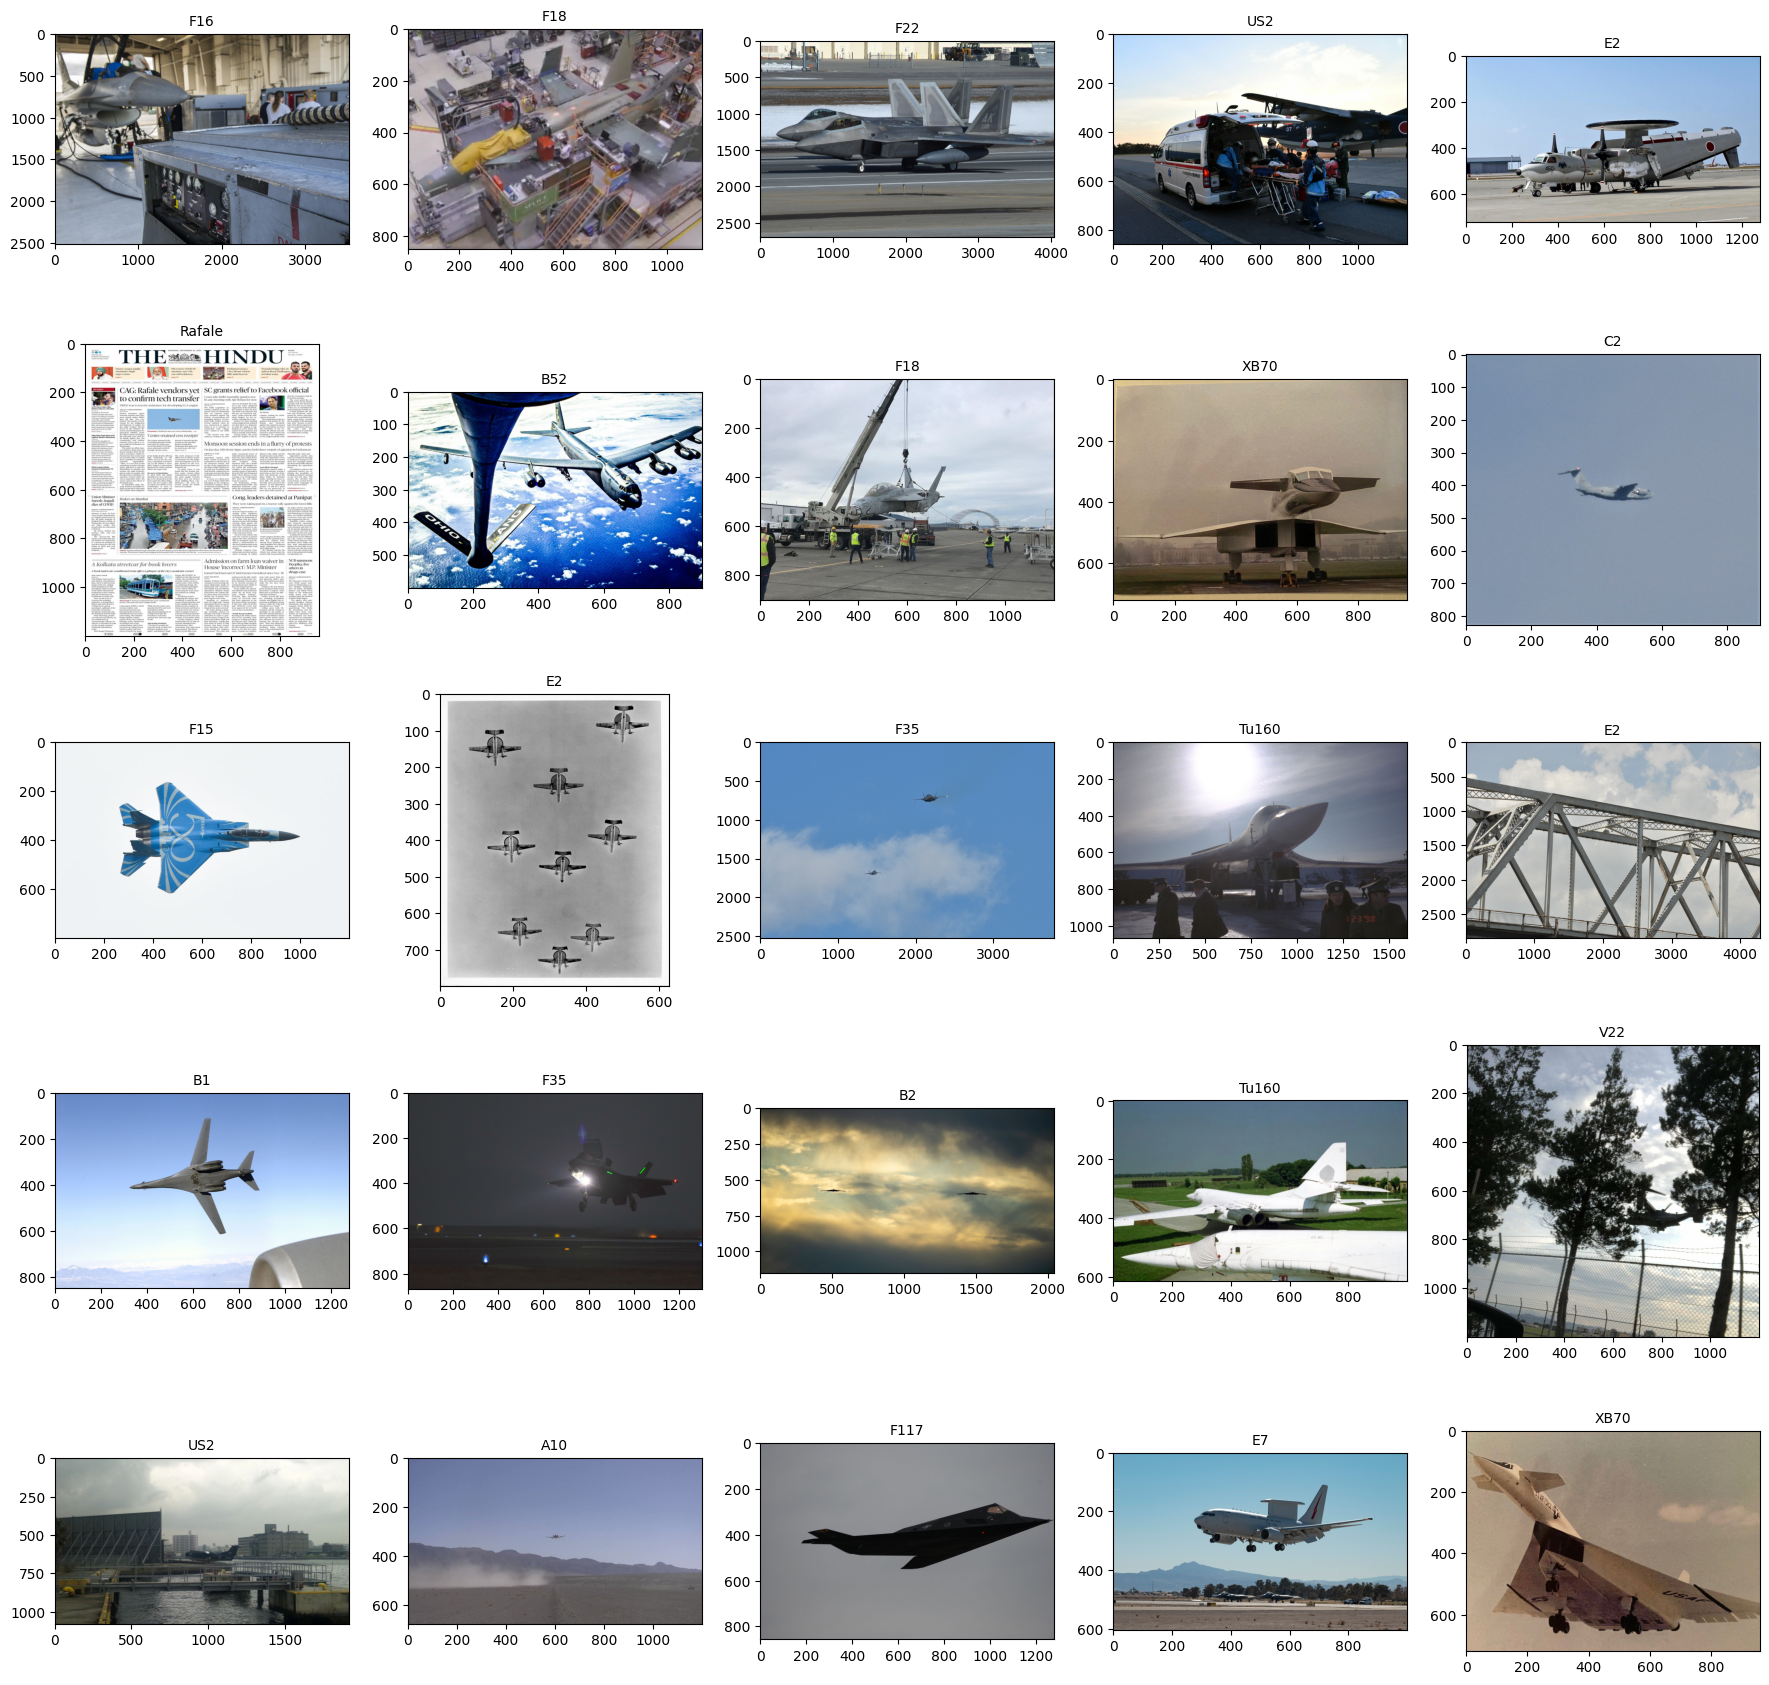

In [32]:
plt.figure(figsize = (22, 22))
plot_counter = 0
for csv in train_csv_paths[:25]:
    df = pd.read_csv(csv)
    filename = df["filename"][0]
    plot_counter += 1
    plt.subplot(5, 5, plot_counter)
    img_path = train_collection_path + "/" + filename + ".jpg"
    image = cv2.imread(img_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    plt.imshow(image)
    class_name = df["class"][0] 
    plt.title(class_name, fontsize= 10)

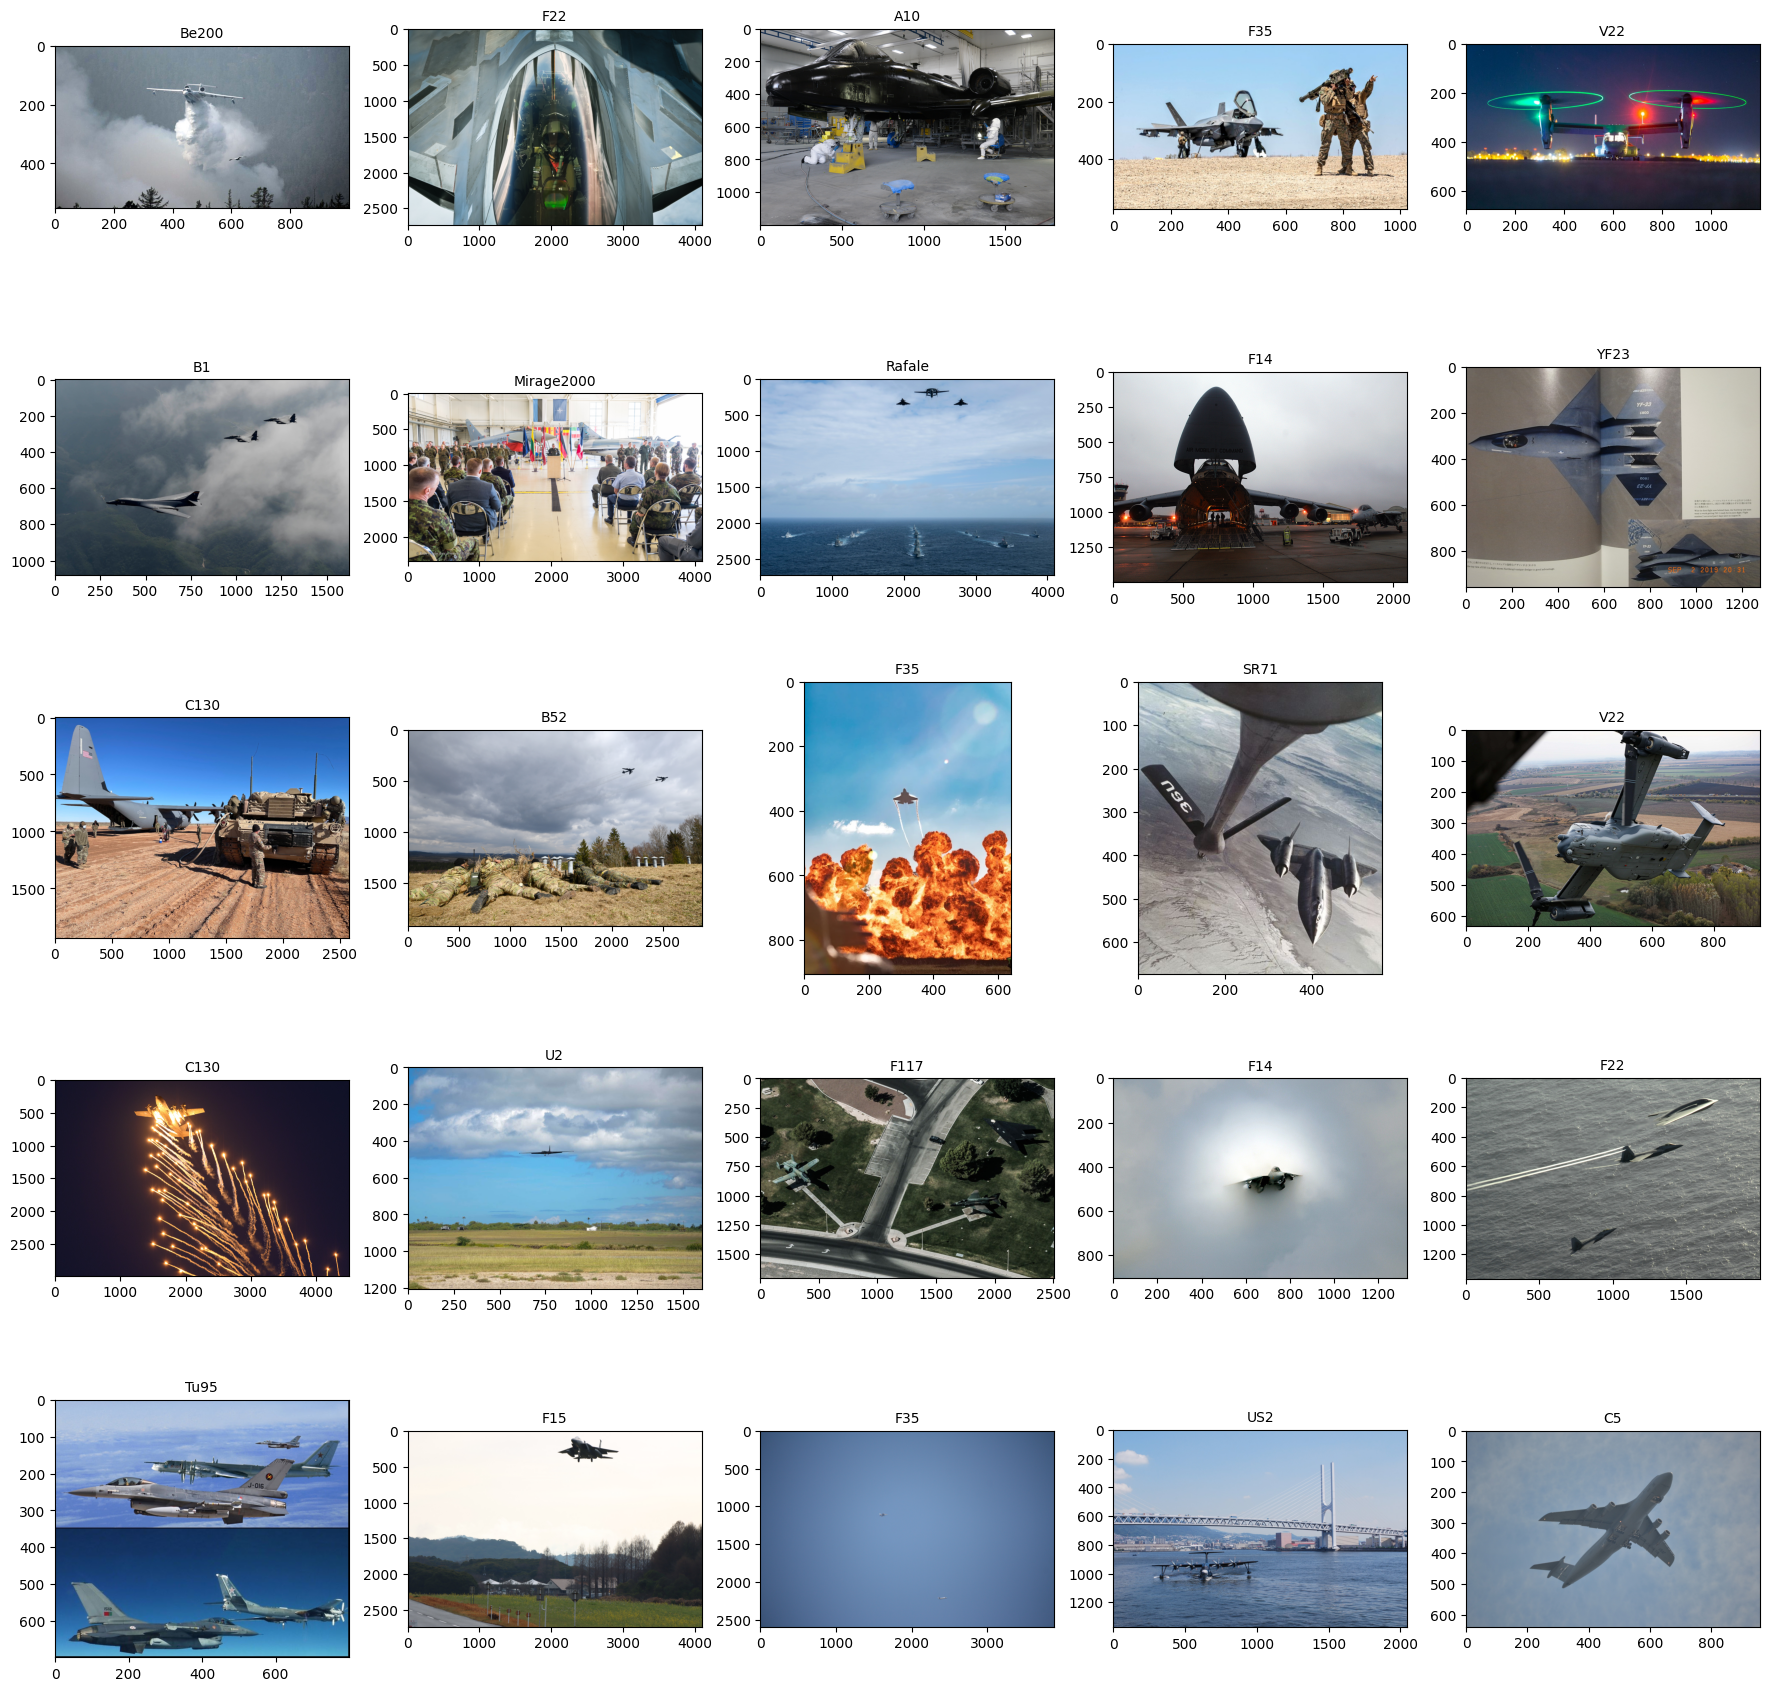

In [33]:
plt.figure(figsize = (22, 22))
plot_counter = 0
for csv in test_csv_paths[:25]:
    df = pd.read_csv(csv)
    filename = df["filename"][0]
    plot_counter += 1
    plt.subplot(5, 5, plot_counter)
    img_path = test_collection_path + "/" + filename + ".jpg"
    image = cv2.imread(img_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    plt.imshow(image)
    class_name = df["class"][0] 
    plt.title(class_name, fontsize= 10)

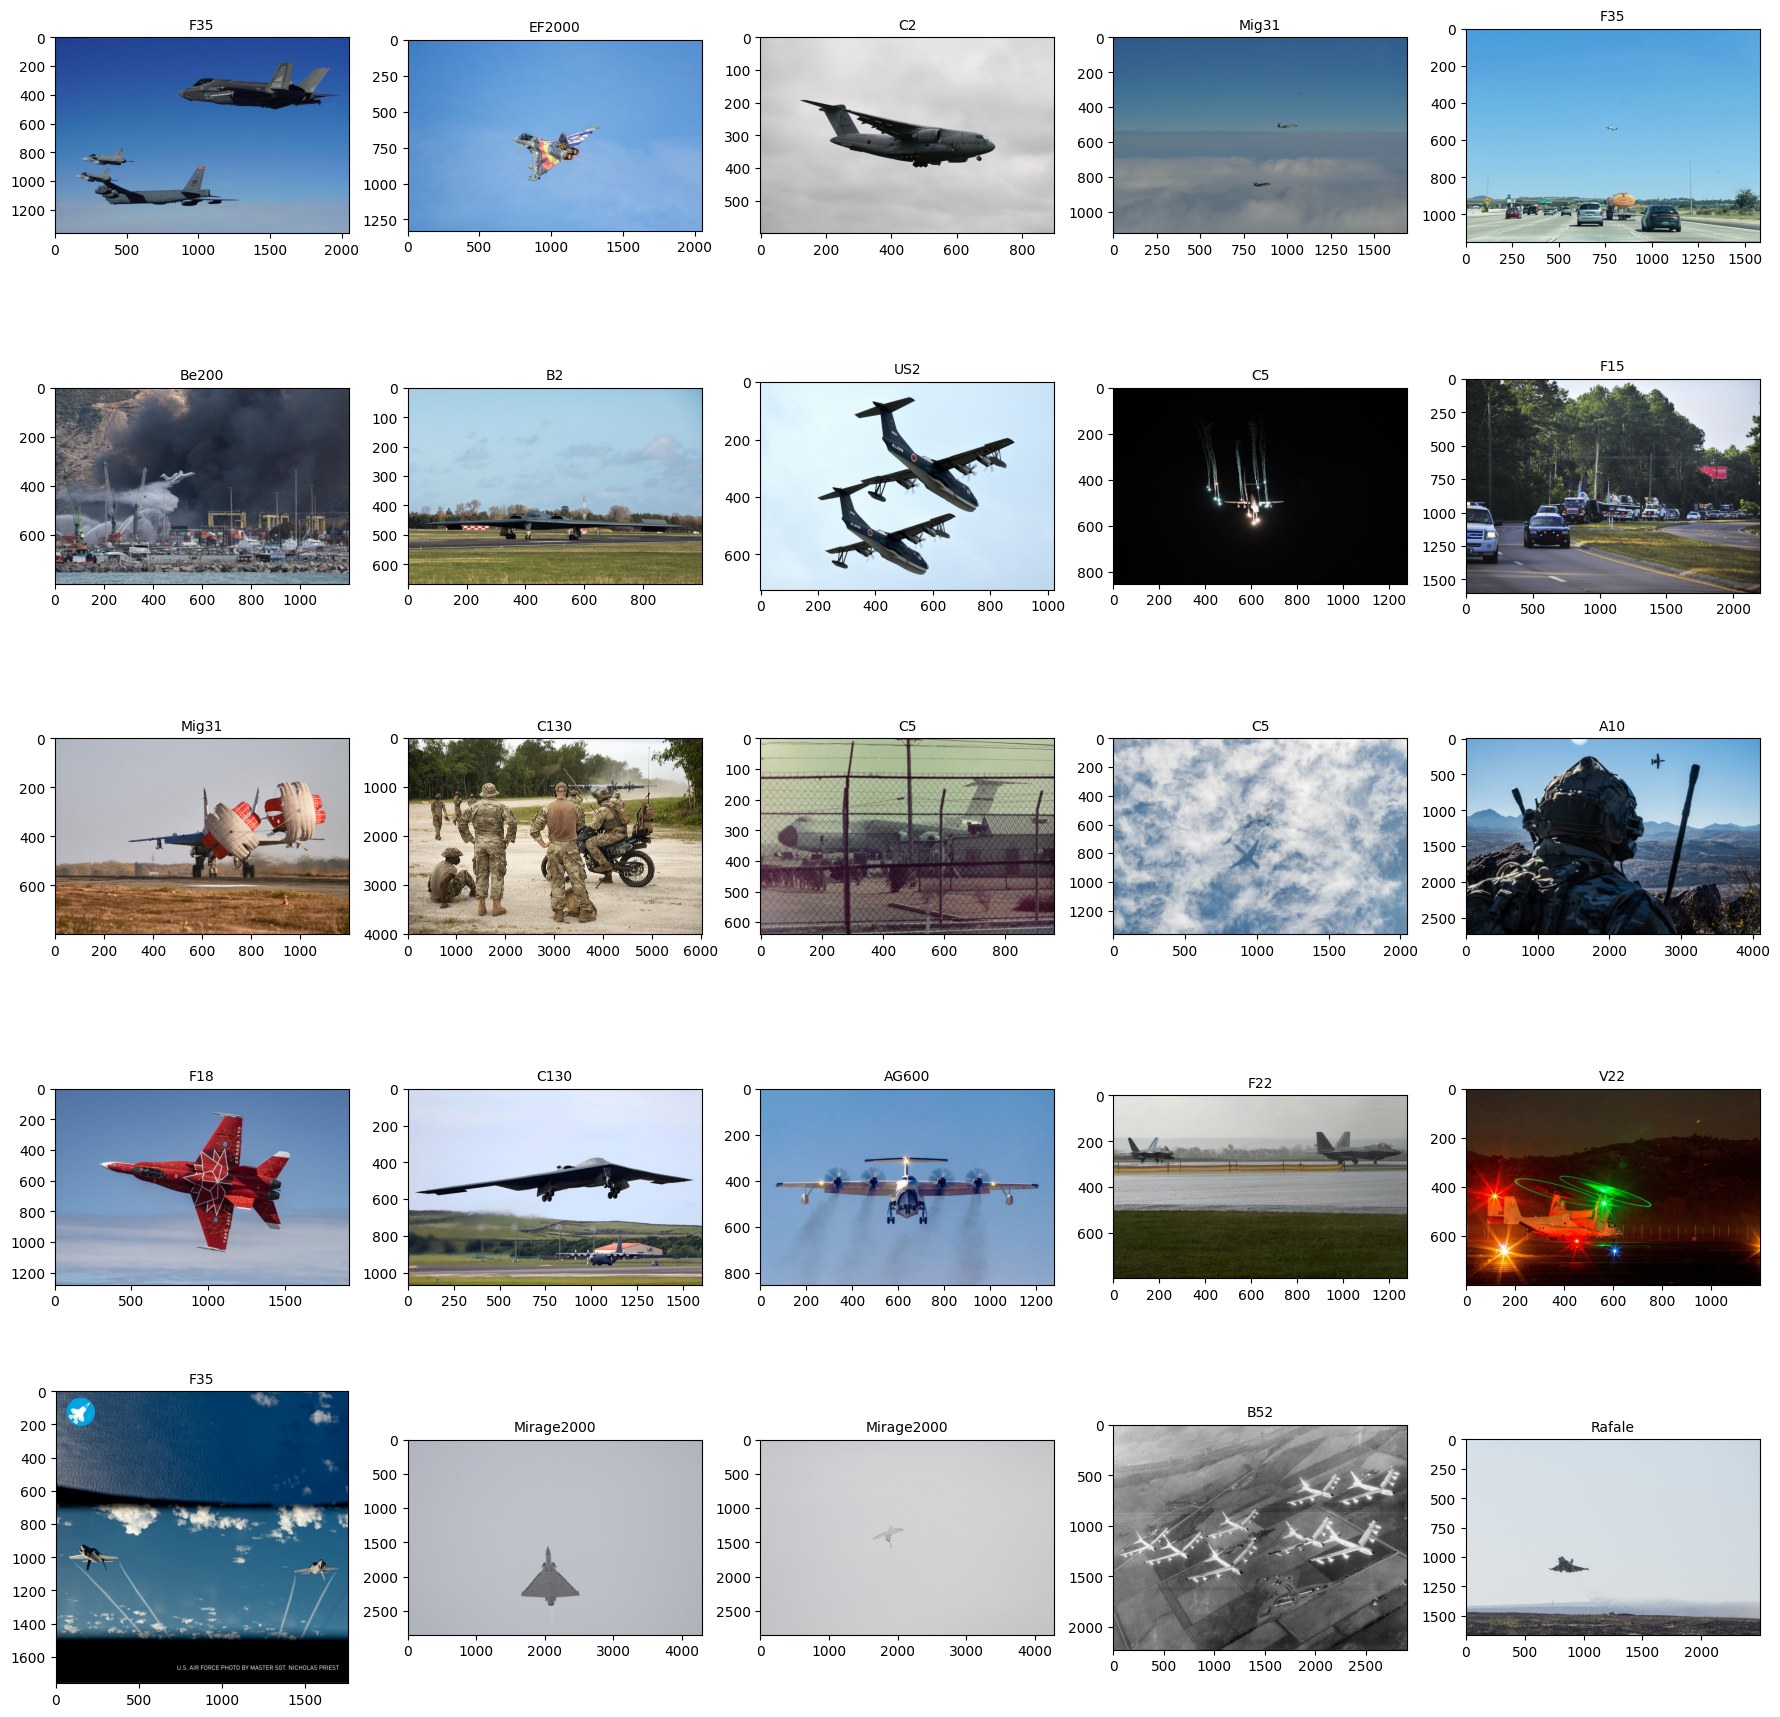

In [34]:
plt.figure(figsize = (22, 22))
plot_counter = 0
for csv in val_csv_paths[:25]:
    df = pd.read_csv(csv)
    filename = df["filename"][0]
    plot_counter += 1
    plt.subplot(5, 5, plot_counter)
    img_path = val_collection_path + "/" + filename + ".jpg"
    image = cv2.imread(img_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    plt.imshow(image)
    class_name = df["class"][0] 
    plt.title(class_name, fontsize= 10)

# Create yaml string to feed into YOLO

In [35]:
all_classes = ', '.join([f'"{cls}"' for cls in class_list])
with open('datasets/ultralytics/data/mad.yaml', mode='w') as file:
    yaml_content = 'train: E:/GA DSIF/Capstone/datasets/ultralytics/data/train\n'\
                   + 'val: E:/GA DSIF/Capstone/datasets/ultralytics/data/val\n'\
                   + 'test: E:/GA DSIF/Capstone/datasets/ultralytics/data/test\n'\
                   + f'nc: {len(class_list)}\n'\
                   + f'names: [{all_classes}]'
    file.write(yaml_content)

print(yaml_content)


train: E:/GA DSIF/Capstone/datasets/ultralytics/data/train
val: E:/GA DSIF/Capstone/datasets/ultralytics/data/val
test: E:/GA DSIF/Capstone/datasets/ultralytics/data/test
nc: 43
names: ["A10", "A400M", "AG600", "AV8B", "B1", "B2", "B52", "Be200", "C130", "C17", "C2", "C5", "E2", "E7", "EF2000", "F117", "F14", "F15", "F16", "F18", "F22", "F35", "F4", "J20", "JAS39", "MQ9", "Mig31", "Mirage2000", "P3", "RQ4", "Rafale", "SR71", "Su34", "Su57", "Tornado", "Tu160", "Tu95", "U2", "US2", "V22", "Vulcan", "XB70", "YF23"]


# What model should we use?

see: arXiv:2304.08069
https://arxiv.org/abs/2304.08069

DETRs Beat YOLOs on Real-time Object Detection

Visual transformers should outperform YOLO. In addition, theoretically speaking, as a CNN, YOLO is likely to perform more poorly due to the pooling layers killing off features in distance features. This is not ideal for our use case, which is scanning the sky for
potentially hostile aircraft. While we will try a YOLO model, we will start with the RT-DETR model as it is likely to give us better performance.


# Instantiate Model and Fit - using augmentation

In [36]:
model = RTDETR(model="rtdetr-l.pt")

result = model.train(name="RTDETR",
                     epochs=100,
                     imgsz=1280,
                     batch=8,
                     optimizer="auto",
                     close_mosaic=0,
                     hsv_h=0.015,
                     hsv_s=0.7,
                     hsv_v=0.4,
                     degrees=0.1,
                     translate=0.25,
                     scale=0.45,
                     shear=0.1,
                     perspective=0.0,
                     flipud=0.1,
                     fliplr=0.5,
                     mosaic=1.0,
                     mixup=0.5,
                     pretrained="rtdetr-l.pt",
                     data="datasets/ultralytics/data/mad.yaml",
                     )


New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=rtdetr-l.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR, exist_ok=False, pretrained=rtdetr-l.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visu

# Results

![results](Assets\detector_results\RT-DETR\results.png)

![results](Assets\detector_results\RT-DETR\val_batch0_pred.jpg)

![results](Assets\detector_results\RT-DETR\val_batch1_pred.jpg)

![results](Assets\detector_results\RT-DETR\val_batch2_pred.jpg)

# Test on some test images:

In [37]:
model = RTDETR(model="runs/detect/RTDETR/weights/best.pt")
model.predict("Assets/test_imgs/f15_guncam.png", save=True)


image 1/1 e:\GA DSIF\Capstone\Assets\test_imgs\f15_guncam.png: 1280x1280 1 F15, 29.0ms
Speed: 7.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'A10', 1: 'A400M', 2: 'AG600', 3: 'AV8B', 4: 'B1', 5: 'B2', 6: 'B52', 7: 'Be200', 8: 'C130', 9: 'C17', 10: 'C2', 11: 'C5', 12: 'E2', 13: 'E7', 14: 'EF2000', 15: 'F117', 16: 'F14', 17: 'F15', 18: 'F16', 19: 'F18', 20: 'F22', 21: 'F35', 22: 'F4', 23: 'J20', 24: 'JAS39', 25: 'MQ9', 26: 'Mig31', 27: 'Mirage2000', 28: 'P3', 29: 'RQ4', 30: 'Rafale', 31: 'SR71', 32: 'Su34', 33: 'Su57', 34: 'Tornado', 35: 'Tu160', 36: 'Tu95', 37: 'U2', 38: 'US2', 39: 'V22', 40: 'Vulcan', 41: 'XB70', 42: 'YF23'}
 orig_img: array([[[ 64,  58,  45],
         [ 64,  58,  45],
         [ 64,  58,  45],
         ...,
         [216, 197, 172],
         [216, 197, 172],
         [216, 197, 172]],
 
        [[ 64,  58,  45],
         [ 64,  58,  45],
         [ 64,  58,  45],
         ...,
         [216, 197, 172],
         [216, 197, 172],
         [216, 197, 172]],
 


![results](Assets\pred_test_results\f15_guncam.png)

# The model is pretty good, but it is making occasional mistakes, and recall is 0.86 - it might benefit from additional augmentation or a cosine lr scheduler. Try those first, then see if another model does better.

# Try increasing augmentations - seems to pick up aircraft from odd colour patterns in stuff like tarmac, etc, so focus on increasing colour augmentation, train from the already trained model

In [3]:
model = RTDETR(model="runs/detect/RTDETR/weights/last.pt")

result = model.train(name="RTDETR_extra_aug",
                     epochs=100,
                     imgsz=1280,
                     batch=8,
                     close_mosaic=0,
                     hsv_h=0.02,  # increase by 0.005
                     hsv_s=0.75,  # increase by 0.5
                     hsv_v=0.45,  # increase by 0.05
                     degrees=0.1, # increase by 0.05
                     translate=0.25, 
                     scale=0.5, # increase by 0.05
                     shear=0.1,
                     perspective=0.0,
                     flipud=0.1,
                     fliplr=0.5,
                     mosaic=1.0,
                     mixup=0.5,
                     pretrained="runs/detect/RTDETR/weights/last.pt",
                     data="datasets/ultralytics/data/mad.yaml",
                     patience=100,
                     )

New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/RTDETR/weights/last.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR_extra_aug, exist_ok=False, pretrained=runs/detect/RTDETR/weights/last.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

In [4]:
model = RTDETR(model="runs/detect/RTDETR_extra_aug/weights/last.pt")

result = model.train(resume=True)

New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=runs\detect\RTDETR_extra_aug\weights\last.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR_extra_aug, exist_ok=False, pretrained=runs/detect/RTDETR/weights/last.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

In [3]:
model = RTDETR(model="runs/detect/RTDETR_extra_aug/weights/last.pt")

result = model.train(resume=True)

New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=runs\detect\RTDETR_extra_aug\weights\last.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR_extra_aug, exist_ok=False, pretrained=runs/detect/RTDETR/weights/last.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

![results](Assets\detector_results\RT-DETR_extra_aug\results.png)

![results](Assets\detector_results\RT-DETR_extra_aug\val_batch0_pred.jpg)

![results](Assets\detector_results\RT-DETR_extra_aug\val_batch1_pred.jpg)

![results](Assets\detector_results\RT-DETR_extra_aug\val_batch2_pred.jpg)

### The metrics on this model seem slightly worse in terms of precision but is slightly better in recall. Recall is important as we want to avoid missing potential threats. In any event, this model seems to perform well on the sort of aircraft image we want - aircraft silhouetted against sky or distant ground. It missed the tightly grouped B-52 in the second val image, and the Gripen on the ground in the third val image, but does not give the same sort of false alarms that the first model did. Aircraft in tactical employment do not group tightly like those B-52s (a single missile would take out more than one ship), and for our use case, we are not interested in aircraft on the ground. 

### This model is therefore preferable to the first.

# What about with less augmentation?

In [4]:
model = RTDETR(model="runs/detect/RTDETR/weights/last.pt")

result = model.train(name="RTDETR_less_aug",
                     epochs=100,
                     imgsz=1280,
                     batch=8,
                     close_mosaic=0,
                     hsv_h=0.01,  # dencrease by 0.005
                     hsv_s=0.65,  # dencrease by 0.5
                     hsv_v=0.35,  # dencrease by 0.05
                     degrees=0.01, # dencrease by 0.04
                     translate=0.25, 
                     scale=0.4, # decrease by 0.05
                     shear=0.1,
                     perspective=0.0,
                     flipud=0.1,
                     fliplr=0.5,
                     mosaic=1.0,
                     mixup=0.5,
                     pretrained="runs/detect/RTDETR/weights/last.pt",
                     data="datasets/ultralytics/data/mad.yaml",
                     patience=100,
                     )

New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/RTDETR/weights/last.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR_less_aug, exist_ok=False, pretrained=runs/detect/RTDETR/weights/last.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

# Try Cosine LR Scheduler

In [5]:
model = RTDETR(model="runs/detect/RTDETR/weights/last.pt")

result = model.train(name="RTDETR_cosine",
                     epochs=100,
                     imgsz=1280,
                     batch=8,
                     close_mosaic=0,
                     cos_lr=True,
                     hsv_h=0.02,  # increase by 0.005
                     hsv_s=0.75,  # increase by 0.5
                     hsv_v=0.45,  # increase by 0.05
                     degrees=0.1, # increase by 0.05
                     translate=0.25, 
                     scale=0.5, # increase by 0.05
                     shear=0.1,
                     perspective=0.0,
                     flipud=0.1,
                     fliplr=0.5,
                     mosaic=1.0,
                     mixup=0.5,
                     pretrained="runs/detect/RTDETR/weights/last.pt",
                     data="datasets/ultralytics/data/mad.yaml",
                     )

New https://pypi.org/project/ultralytics/8.0.221 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/RTDETR/weights/last.pt, data=datasets/ultralytics/data/mad.yaml, epochs=100, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RTDETR_cosine, exist_ok=False, pretrained=runs/detect/RTDETR/weights/last.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_

# YOLOv8

In [ ]:
model = YOLO("yolov8m.pt")
results = model.train(data='datasets/ultralytics/data/mad.yaml',
                      pretrained="yolov8m.pt",
                      epochs=100, 
                      imgsz=1280, 
                      batch=8, 
                      patience=50,
                      momentum=0.935, 
                      weight_decay=0.0005,
                      warmup_epochs=2.0,
                      warmup_momentum=0.8,
                      warmup_bias_lr=0.0001,
                      box=7.5,
                      cls=0.5,
                      dfl=1.5,
                      hsv_h=0.02,  
                      hsv_s=0.75, 
                      hsv_v=0.45,  
                      degrees=0.1, 
                      translate=0.25, 
                      scale=0.5, 
                      shear=0.1,
                      flipud=0.1,
                      fliplr=0.5,
                      mosaic=1.0,
                      mixup=0.5,
                      )

# Results

| Model        | Epochs | Precision | Recall    | mAP50      | Remarks                                    |
|--------------|--------|-----------|-----------|------------|--------------------------------------------|
|RT-DETR       |100     |0.953      |0.866      |0.902       |This performance is acceptable              |
|RT-DETR       |100     |0.936      |0.875      |0.905       |With additional augmentation                |
|RT-DETR       |100     |0.953      |0.849      |0.889       |With less augmentation                      |
|RT-DETR       |100     |0.TBA      |0.TBA      |0.TBA       |Cosine LR scheduler                         |
|YOLOv8        |100     |0.TBA      |0.TBA      |0.TBA       |TBA                                         |
